In [27]:
import sqlalchemy as db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 500

# TODOs:

- Clean out some outlier and then plot
- Check relationship on 2 weeks or month level, since rec data should be longer term valuation impact
- Visualize or compute how each firm does regard to their recommendation, are they being honest?

# Preliminary Data Processing

In [4]:
con = db.create_engine("sqlite:///C:/Users/zheji/Desktop/TradingTools/fundamentalDB.sqlite")
con1 = db.create_engine('sqlite:///C:/Users/zheji/Desktop/TradingTools/'+'dailyDB'+'.sqlite')
rec = pd.read_sql_query("SELECT * FROM recommendation", con)

In [7]:
spy = pd.read_sql('SPY', con1)
spy['market_3month_ret'] = (spy['Adj Close'].shift(-60) - spy['Adj Close'])/ spy['Adj Close'] * 100
spy['market_month_ret'] = (spy['Adj Close'].shift(-30) - spy['Adj Close'])/ spy['Adj Close'] * 100
spy['market_week_ret'] = (spy['Adj Close'].shift(-5) - spy['Adj Close'])/ spy['Adj Close'] * 100
spy['market_daily_ret'] = (spy['Adj Close'].shift(-1) - spy['Adj Close'])/ spy['Adj Close'] * 100
spy['market_past5_ret'] = (spy['Adj Close'].pct_change(5))* 100

In [8]:
dfs = []
for table in con1.table_names():
    df = pd.read_sql(table, con1)
    df['ticker'] = table
    df['3month_ret'] = (df['Adj Close'].shift(-60) - df['Adj Close'])/ df['Adj Close'] * 100
    df['month_ret']= (df['Adj Close'].shift(-20) - df['Adj Close'])/ df['Adj Close'] * 100
    df['week_ret'] = (df['Adj Close'].shift(-5) - df['Adj Close'])/ df['Adj Close'] * 100
    df['daily_ret']= (df['Adj Close'].shift(-1) - df['Adj Close'])/ df['Adj Close'] * 100
    df['past5_ret'] = df['Adj Close'].pct_change(5) * 100
    df = pd.merge(df, spy, on ='Date')
    df['beta'] = (df['daily_ret'].rolling(60).std()/df['market_daily_ret'].rolling(60).std()) * (df['Adj Close_x'].rolling(60).corr(df['Adj Close_y']))
    dfs.append(df)
daily = pd.concat(dfs)

In [9]:
daily.head(5)

,Date,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,ticker,3month_ret,month_ret,...,Low_y,Close_y,Adj Close_y,Volume_y,market_3month_ret,market_month_ret,market_week_ret,market_daily_ret,market_past5_ret,beta
0,2018-01-02,67.419998,67.889999,67.339996,67.599998,66.243683,1047800.0,A,-1.035508,8.624249,...,267.399994,268.769989,257.345001,86655700,-1.698878,0.305099,2.146814,0.632503,NaN,NaN
1,2018-01-03,67.620003,69.489998,67.599998,69.320000,67.929161,1698900.0,A,-6.846767,5.063474,...,268.959991,270.470001,258.972717,90070400,-4.425197,0.946486,1.349490,0.421482,NaN,NaN
2,2018-01-04,69.540001,69.820000,68.779999,68.800003,67.419609,2230700.0,A,-4.700558,3.561031,...,270.540009,271.609985,260.064240,80636400,-3.606486,0.552267,1.660462,0.666398,NaN,NaN
3,2018-01-05,68.730003,70.099998,68.730003,69.900002,68.497528,1632500.0,A,-6.157233,-2.403446,...,271.950012,273.420013,261.797302,83524000,-3.220104,-0.738782,1.645833,0.182886,NaN,NaN
4,2018-01-08,69.730003,70.330002,69.550003,70.050003,68.644516,1613400.0,A,-6.029104,-2.284089,...,272.980011,273.920013,262.276093,57319200,-2.634385,-1.412838,1.113464,0.226337,NaN,NaN


In [10]:
df = pd.merge(rec, daily, how='inner', on=['Date', 'ticker'])
df = df.dropna()
#df = pd.merge(df, spy, on ='Date')

In [33]:
df['3month_excess'] = df['3month_ret'] - df['market_3month_ret'] * df['beta']
df['month_excess'] = df['month_ret'] - df['market_month_ret']  * df['beta']
df['week_excess'] = df['week_ret'] - df['market_week_ret'] * df['beta']
df['day_excess'] = df['daily_ret'] - df['market_daily_ret'] * df['beta']
df['past5_excess'] = df['past5_ret'] - df['market_past5_ret'] * df['beta']

In [12]:
df.head(5)

,Firm,To Grade,From Grade,Action,ticker,Date,Time,Open_x,High_x,Low_x,...,market_3month_ret,market_month_ret,market_week_ret,market_daily_ret,market_past5_ret,beta,3month_excess,month_excess,week_excess,day_excess
20,Stifel Nicolaus,Buy,Buy,main,MSFT,2018-04-27,11:55:17,97.599998,97.900002,93.910004,...,6.120387,4.501778,-0.202606,-0.769063,-0.018742,1.142821,5.848984,-2.049001,-0.457251,-1.521445
21,Canaccord Genuity,Buy,Buy,main,MSFT,2018-04-27,12:13:32,97.599998,97.900002,93.910004,...,6.120387,4.501778,-0.202606,-0.769063,-0.018742,1.142821,5.848984,-2.049001,-0.457251,-1.521445
22,JP Morgan,Overweight,Neutral,up,MSFT,2018-04-27,12:42:37,97.599998,97.900002,93.910004,...,6.120387,4.501778,-0.202606,-0.769063,-0.018742,1.142821,5.848984,-2.049001,-0.457251,-1.521445
23,Barclays,Overweight,Overweight,main,MSFT,2018-04-27,13:45:41,97.599998,97.900002,93.910004,...,6.120387,4.501778,-0.202606,-0.769063,-0.018742,1.142821,5.848984,-2.049001,-0.457251,-1.521445
24,Stifel Nicolaus,Buy,Buy,main,MSFT,2018-04-27,11:55:17,97.599998,97.900002,93.910004,...,6.120387,4.501778,-0.202606,-0.769063,-0.018742,1.142821,5.848984,-2.049001,-0.457251,-1.521445


In [13]:
df = df.drop_duplicates()
#df = df[df['Date'] < '2019-12-01'] # pre covid
df.shape

(13968, 34)

# equity abs retrun VS rec data

Scatter plot for main recommendation


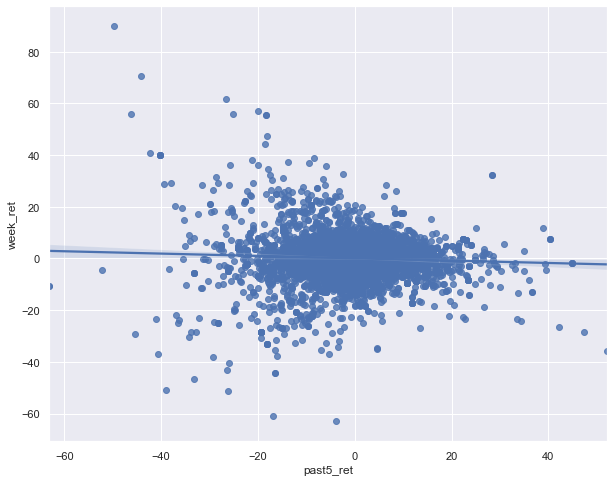

Scatter plot for up recommendation


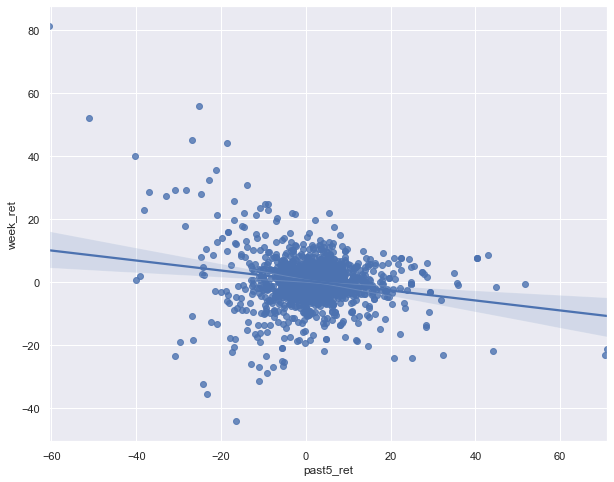

Scatter plot for down recommendation


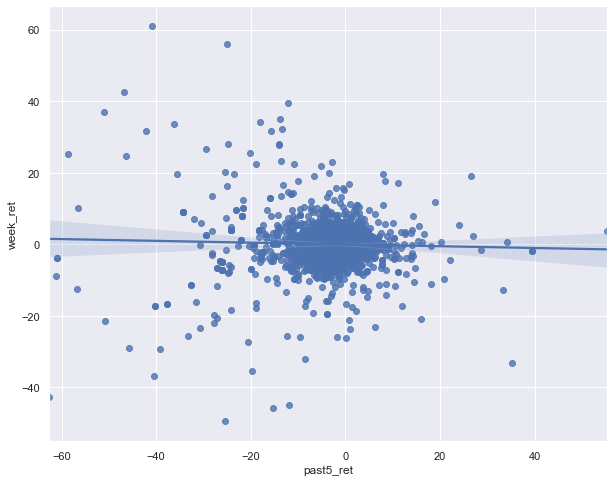

Scatter plot for reit recommendation


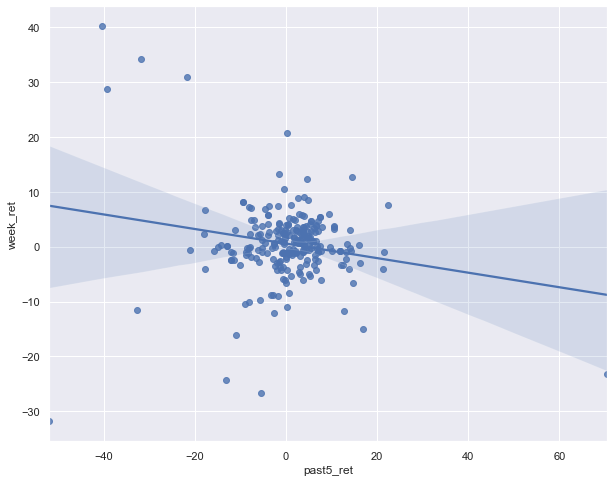

In [31]:
# scatter plot for each action group, past5 day return versus next 5 day return
groupdf = df.groupby('Action')
sns.set(rc={'figure.figsize':(10,8)})
for action in df.Action.unique():
    print("Scatter plot for {} recommendation".format(action))
    tmp = groupdf.get_group(action)
    sns.regplot(x=tmp['past5_ret'], y=tmp['week_ret'])
    plt.show()

Scatter plot for Buy recommendation


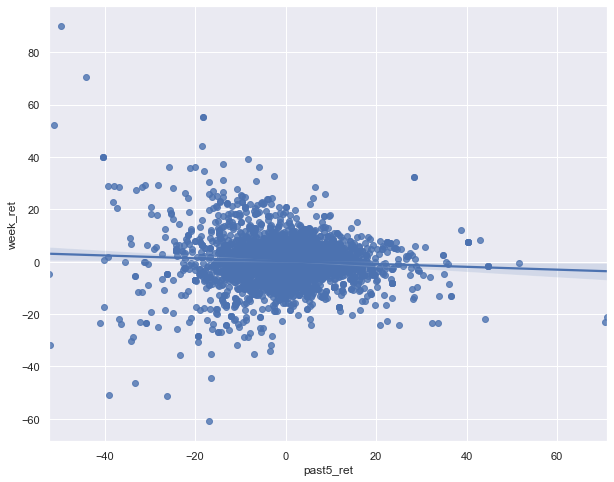

Scatter plot for Hold recommendation


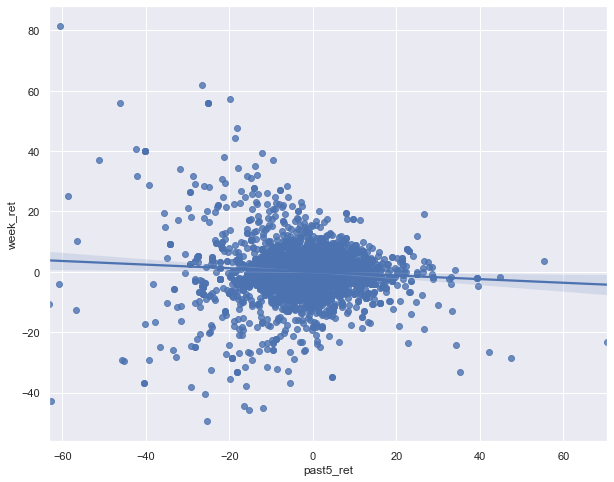

Scatter plot for Strong Buy recommendation


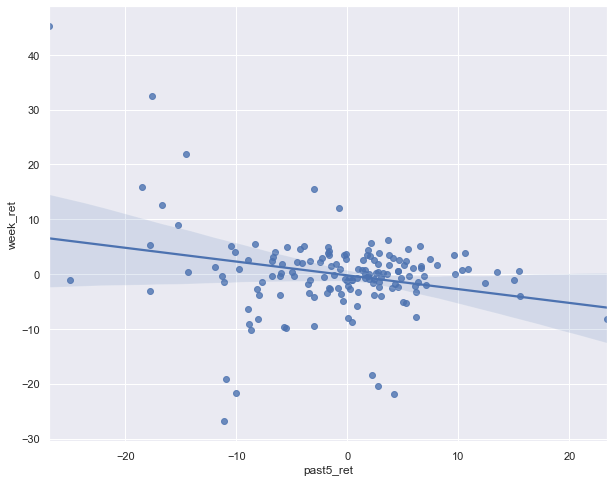

Scatter plot for Sell recommendation


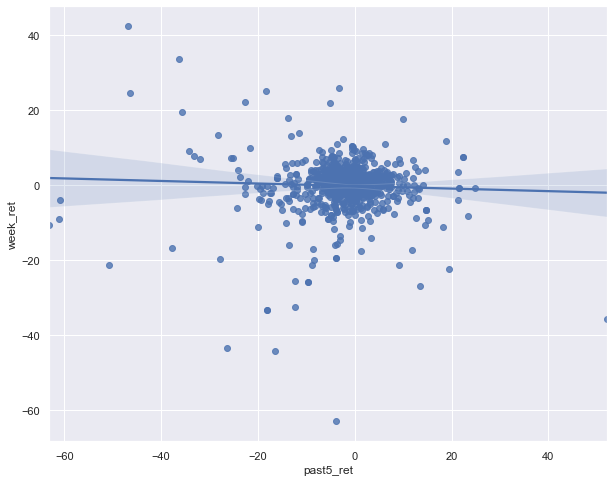

Scatter plot for N/A recommendation


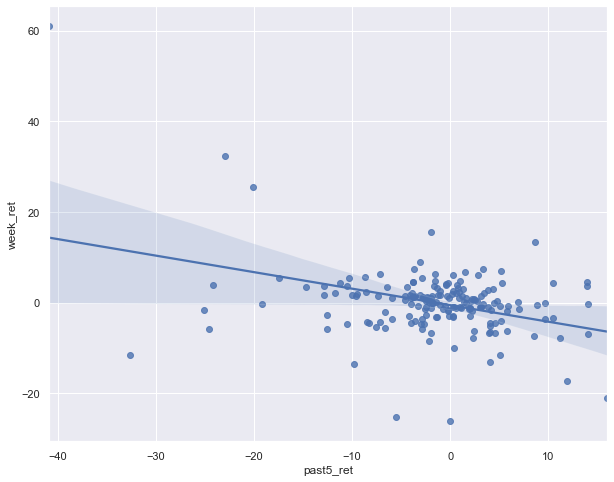

In [32]:
# scatter plot for each grade group, past5 day return versus next 5 day return
groupdf = df.groupby('To Grade')
for action in df['To Grade'].unique():
    print("Scatter plot for {} recommendation".format(action))
    tmp = groupdf.get_group(action)
    sns.regplot(x=tmp['past5_ret'], y=tmp['week_ret'])
    plt.show()

In [61]:
stats = pd.DataFrame()  # mean comparison between analyst actions
stats['mean_3month_ret'] = df.groupby('Action')['3month_ret'].mean()
stats['mean_monthly_ret'] = df.groupby('Action').month_ret.mean()
stats['std_monthly_ret'] = df.groupby('Action').month_ret.std()
stats['mean_weekly_ret'] = df.groupby('Action').week_ret.mean()
stats['mean_daily_ret'] = df.groupby('Action').daily_ret.mean()
stats['num_obs'] = df.groupby('Action').daily_ret.count()
stats

,mean_3month_ret,mean_monthly_ret,std_monthly_ret,mean_weekly_ret,mean_daily_ret,num_obs
Action,,,,,,
down,1.630370,1.132082,12.896058,0.307882,-0.037286,2416
main,2.004926,1.584083,11.726691,0.283705,-0.108352,13435
reit,3.724262,2.640799,12.049739,1.119476,0.103245,328
up,2.167269,1.595844,12.424174,0.348412,0.137189,2459


In [62]:
stats = pd.DataFrame()  # median comparison between analyst actions, get rid of potential outlier effect
stats['mean_3month_ret'] = df.groupby('Action')['3month_ret'].median()
stats['mean_monthly_ret'] = df.groupby('Action').month_ret.median()
stats['std_monthly_ret'] = df.groupby('Action').month_ret.std()
stats['mean_weekly_ret'] = df.groupby('Action').week_ret.median()
stats['mean_daily_ret'] = df.groupby('Action').daily_ret.median()
stats['num_obs'] = df.groupby('Action').daily_ret.count()
stats

,mean_3month_ret,mean_monthly_ret,std_monthly_ret,mean_weekly_ret,mean_daily_ret,num_obs
Action,,,,,,
down,1.627124,1.355924,12.896058,0.292864,0.000000,2416
main,2.076889,1.662809,11.726691,0.331267,0.008498,13435
reit,5.145923,3.006103,12.049739,0.605543,0.021575,328
up,2.424823,1.676884,12.424174,0.473618,0.128607,2459


In [14]:
stats = pd.DataFrame()  # mean comparison between Analyst view
stats['mean_3monthly_ret'] = df.groupby('To Grade')['3month_ret'].mean()
stats['mean_monthly_ret'] = df.groupby('To Grade').month_ret.mean()
stats['mean_weekly_ret'] = df.groupby('To Grade').week_ret.mean()
stats['mean_daily_ret'] = df.groupby('To Grade').daily_ret.mean()
stats['num_obs'] = df.groupby('To Grade').daily_ret.count()
stats = stats[stats['num_obs'] > 10]
stats

grade_map = {'Sell': ['Sell', 'Reduce', 'Underperform', 'Underweight'],
             'Hold': ['Equal-Weight', 'In-Line', 'Hold', 'Market Perform', 'Neutral', 'Perform',],
             'Buy': ['Buy', 'Market Outperform', 'Outperform', 'Overweight'],
             'Strong Buy': ['Strong Buy']}
def grade_mapping(x):
    for k, v in grade_map.items():
        if x in v:
            return k
    return 'N/A'
df['To Grade'] = df['To Grade'].apply(grade_mapping)

In [48]:
stats = pd.DataFrame()
stats['mean_monthly_ret'] = df.groupby(['Firm', 'Action']).month_ret.mean()
stats['num_obs'] = df.groupby(['Firm', 'Action']).month_ret.count()
stats
#stats = stats.sort_values('num_obs', ascending=False)

# Excess of Market Return

In [101]:
group_df = df.groupby('To Grade')
for grade in df['To Grade'].unique():
    group = group_df.get_group(grade)
    print('-'*50)
    print(grade)
    print('-'*50)
    print(group.groupby('ticker')[['Firm', 'To Grade', 'From Grade']].count().sort_values('Firm', ascending=False))

--------------------------------------------------
Buy
--------------------------------------------------
        Firm  To Grade  From Grade
ticker                            
AAPL     126       126         126
FB        99        99          99
AMZN      94        94          94
NFLX      75        75          75
NVDA      74        74          74
MSFT      72        72          72
NKE       65        65          65
MU        62        62          62
MA        62        62          62
GOOGL     59        59          59
AVGO      58        58          58
V         55        55          55
ADBE      55        55          55
NOW       54        54          54
FANG      53        53          53
PYPL      52        52          52
AMAT      50        50          50
LOW       47        47          47
MCD       47        47          47
INTC      46        46          46
CMG       45        45          45
ATVI      45        45          45
LRCX      45        45          45
ADSK      42       

Scatter plot for main recommendation


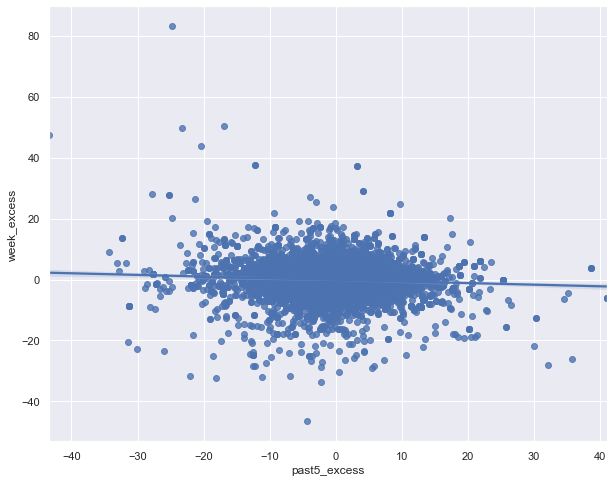

Scatter plot for up recommendation


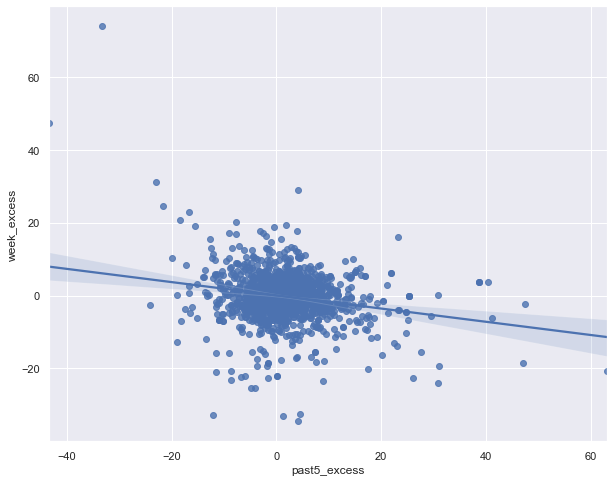

Scatter plot for down recommendation


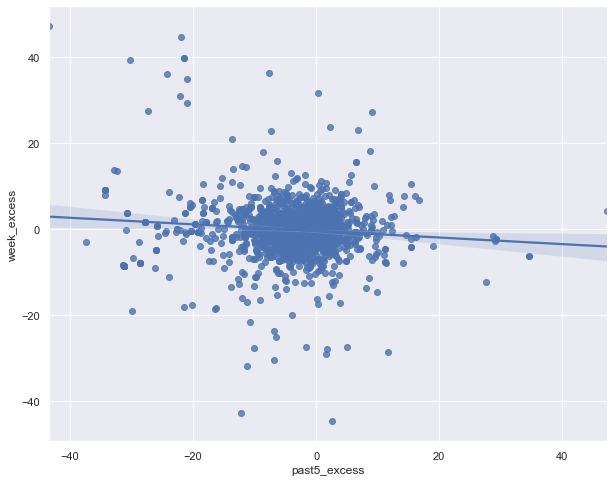

Scatter plot for reit recommendation


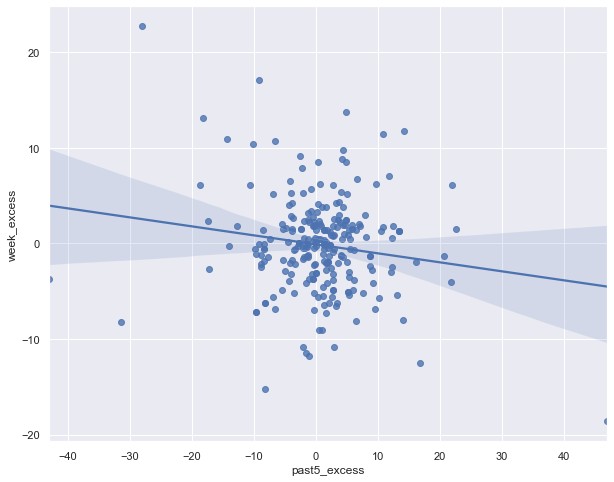

In [34]:
groupdf = df.groupby('Action')
sns.set(rc={'figure.figsize':(10,8)})
for action in df.Action.unique():
    print("Scatter plot for {} recommendation".format(action))
    tmp = groupdf.get_group(action)
    sns.regplot(x=tmp['past5_excess'], y=tmp['week_excess'])
    plt.show()

In [102]:
stats = pd.DataFrame()  # mean comparison between Analyst view
stats['mean_3monthly_ret'] = df.groupby('To Grade')['3month_excess'].mean()
stats['mean_monthly_ret'] = df.groupby('To Grade').month_excess.mean()
stats['std_month_ret'] = df.groupby('To Grade').month_excess.std()
stats['mean_weekly_ret'] = df.groupby('To Grade').week_excess.mean()
stats['mean_daily_ret'] = df.groupby('To Grade').day_excess.mean()
stats['num_obs'] = df.groupby('To Grade').month_excess.count()
stats = stats[stats['num_obs'] > 100]
stats

,mean_3monthly_ret,mean_monthly_ret,std_month_ret,mean_weekly_ret,mean_daily_ret,num_obs
To Grade,,,,,,
Buy,1.603708,1.180788,14.951950,-0.110102,-0.041884,7241
Hold,-0.170847,0.066846,15.480618,-0.206441,-0.108805,5441
N/A,-0.827030,1.069234,18.429237,0.294747,0.100650,181
Sell,0.547104,-0.039632,14.183373,-0.229745,-0.102388,852
Strong Buy,-1.928670,-0.012561,20.783913,-0.291197,-0.150579,153


In [86]:
stats = pd.DataFrame()  # mean comparison between Analyst view
stats['mean_3monthly_ret'] = df.groupby('Action')['3month_excess'].mean()
stats['mean_monthly_ret'] = df.groupby('Action').month_excess.mean()
stats['mean_weekly_ret'] = df.groupby('Action').week_excess.mean()
stats['mean_daily_ret'] = df.groupby('Action').day_excess.mean()
stats['num_obs'] = df.groupby('Action').month_excess.count()
stats

,mean_3monthly_ret,mean_monthly_ret,mean_weekly_ret,mean_daily_ret,num_obs
Action,,,,,
down,-0.992938,-0.756805,-0.172806,-0.288044,1935
main,1.131788,1.099212,-0.125008,-0.051387,9793
reit,4.703326,3.382625,-0.200565,0.035757,242
up,0.212727,-0.551700,-0.263605,0.034033,1898
